In [1]:
# PyTorch & Torchvision
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.02MB/s]


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
class CNN_PyTorch(nn.Module):
    def __init__(self):
        super(CNN_PyTorch, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model_pt = CNN_PyTorch()


In [5]:
model_tf = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

for epoch in range(5):  # 5 epochs
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model_pt(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")


Epoch 1, Loss: 0.4125078798436534
Epoch 2, Loss: 0.25837280689430897
Epoch 3, Loss: 0.20623635600354753
Epoch 4, Loss: 0.17257661273532204
Epoch 5, Loss: 0.14027707812302848


In [7]:
model_tf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_tf.fit(x_train, y_train, epochs=5)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 153s 81ms/step - accuracy: 0.8223 - loss: 0.4941
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 199s 79ms/step - accuracy: 0.9140 - loss: 0.2327
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 199s 78ms/step - accuracy: 0.9372 - loss: 0.1713
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 147s 78ms/step - accuracy: 0.9533 - loss: 0.1258
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 78ms/step - accuracy: 0.9661 - loss: 0.0909


In [8]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model_pt(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'PyTorch Test Accuracy: {100 * correct / total:.2f}%')


PyTorch Test Accuracy: 91.89%


In [9]:
test_loss, test_acc = model_tf.evaluate(x_test, y_test)
print(f'TensorFlow Test Accuracy: {test_acc * 100:.2f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9200 - loss: 0.2790
TensorFlow Test Accuracy: 92.09%


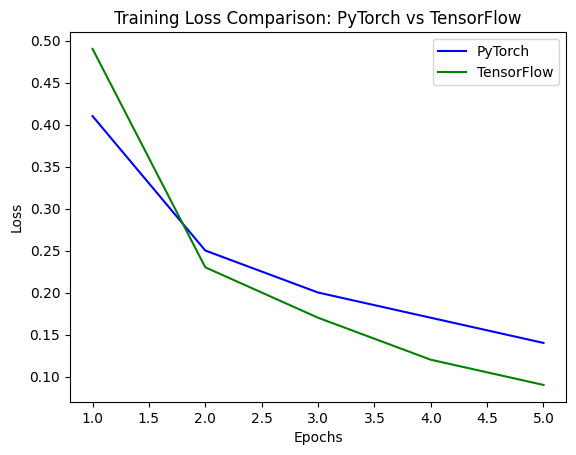

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

pytorch_losses = [0.41, 0.25, 0.20, 0.17, 0.14]
tensorflow_losses = [0.49, 0.23, 0.17, 0.12, 0.09]

# Epochs (X-axis)
epochs = range(1, len(pytorch_losses) + 1)

# Plotting the loss curves for both PyTorch and TensorFlow
plt.plot(epochs, pytorch_losses, label="PyTorch", color='blue')
plt.plot(epochs, tensorflow_losses, label="TensorFlow", color='green')

plt.title('Training Loss Comparison: PyTorch vs TensorFlow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("loss_comparison.png")


In [15]:
from google.colab import files
files.download("loss_comparison.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

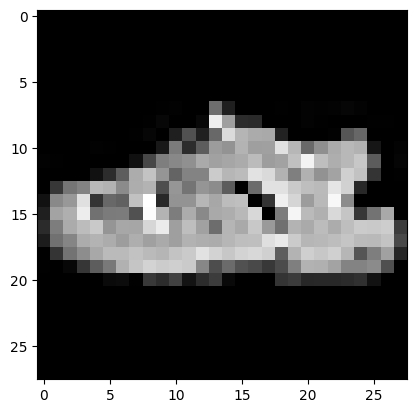

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted label: 5


In [12]:
import random
i = random.randint(0, len(x_test))
img = x_test[i]
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.show()
pred = model_tf.predict(img.reshape(1, 28, 28, 1))
print(f"Predicted label: {np.argmax(pred)}")


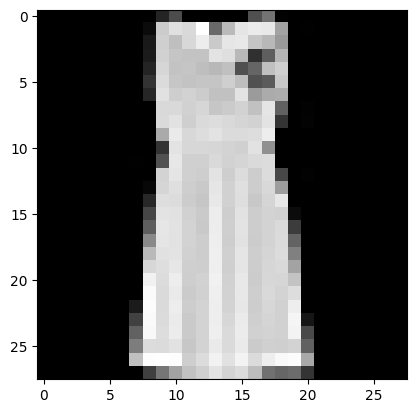

Predicted label: 3


In [13]:
img, label = testset[random.randint(0, len(testset))]
plt.imshow(img.squeeze(), cmap='gray')
plt.show()
img = img.unsqueeze(0)
output = model_pt(img)
pred = output.argmax().item()
print(f"Predicted label: {pred}")


              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.84      0.91      0.87      1000
           3       0.91      0.93      0.92      1000
           4       0.88      0.86      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.82      0.70      0.76      1000
           7       0.94      0.99      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



<Axes: >

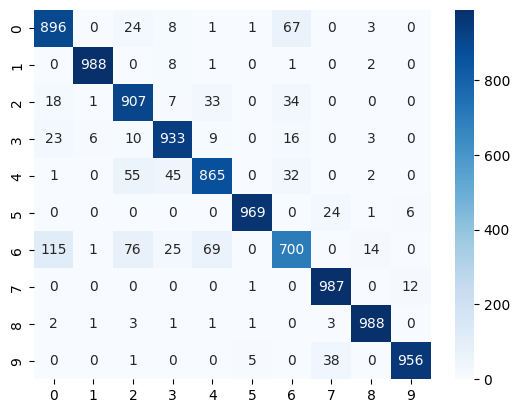

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model_pt(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.90      0.85      0.88      1000
           3       0.93      0.92      0.92      1000
           4       0.82      0.92      0.87      1000
           5       0.98      0.99      0.99      1000
           6       0.82      0.72      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



<Axes: >

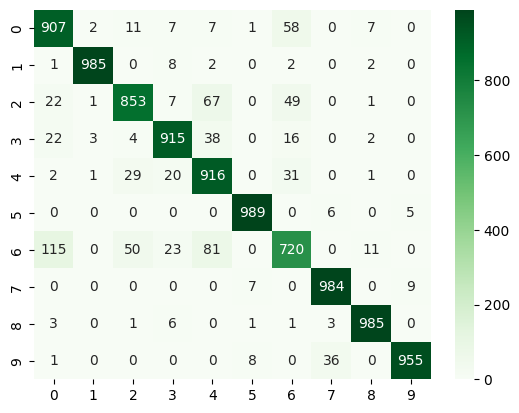

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_tf = model_tf.predict(x_test)
y_pred_classes = np.argmax(y_pred_tf, axis=1)

print(classification_report(y_test, y_pred_classes))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")


In [2]:
import torch
import tensorflow as tf

print("PyTorch CUDA available:", torch.cuda.is_available())
print("TensorFlow GPU devices:", tf.config.list_physical_devices('GPU'))


PyTorch CUDA available: True
TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print("PyTorch CUDA available:", torch.cuda.is_available())
print("TensorFlow GPU devices:", tf.config.list_physical_devices('GPU'))


PyTorch CUDA available: True
TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


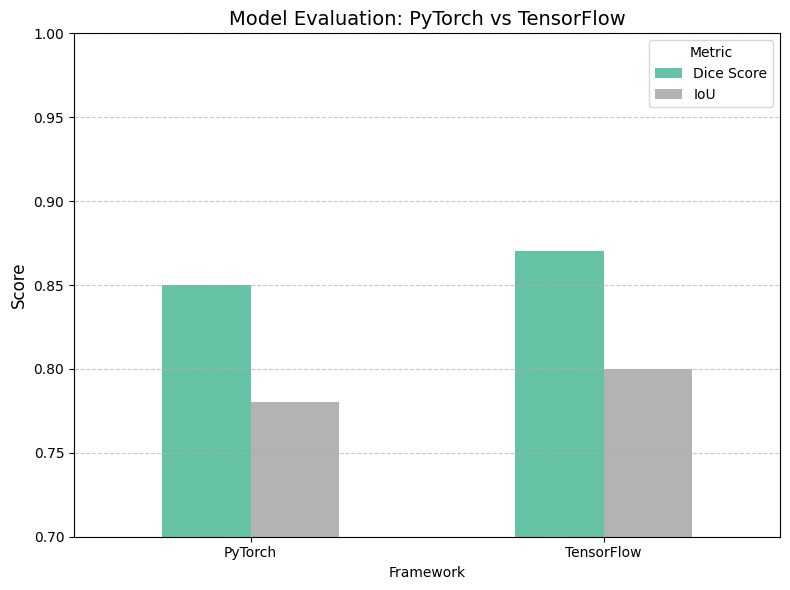

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Example metric data
data = {
    'Framework': ['PyTorch', 'TensorFlow'],
    'Dice Score': [0.85, 0.87],
    'IoU': [0.78, 0.80]
}

df = pd.DataFrame(data)


ax = df.set_index('Framework').plot(kind='bar', figsize=(8, 6), ylim=(0.7, 1), colormap='Set2')
plt.title('Model Evaluation: PyTorch vs TensorFlow', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()


plt.savefig('model_comparison.png', dpi=300)

plt.show()


In [9]:
from google.colab import files
files.download('model_comparison.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>